# **Autoregressive(AR) Models**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

**GOALS**

- Create Autoregressive(AR) Model to predict NO2(GT) Readings

## **PREPARE DATA**

**Wrangle Function**

In [2]:
def wrangle(filepath):
    """Imports csv file, creates a new column 'Timestamp' by combining 'Time' and 'Date' columns,
    and extracts 'Timestamp' and 'NO2(GT)' as a time-indexed Series.

    Args:
        filepath (str): Path to the csv file.
    Returns:
        y (pd.Series): Series with 'Timestamp' as index and 'NO2(GT)' values.
    """
    
    # Read csv file
    data = pd.read_csv(filepath)
      
    # Create 'Timestamp' column by combining 'Date' and 'Time' columns
    data["Timestamp"] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
      
    # Localize 'Timestamp' to CET timezone
    data["Timestamp"] = data["Timestamp"].dt.tz_localize('CET', ambiguous='NaT', nonexistent='NaT')

    # Extract DataFrame with 'Timestamp' and 'NO2(GT)'
    df = data[["Timestamp", "NO2(GT)"]].copy()
    df.set_index("Timestamp", inplace=True)

    # Remove outliers
    df = df[(df["NO2(GT)"] != -200) & (df["NO2(GT)"] <= 300)]
    
    # Resample to 1hr window
    y = df["NO2(GT)"].resample("h").mean().ffill() 
    
    # Explicitly set the frequency of the Series
    y.index.freq = 'H' 
    
    return y




In [3]:
# Testing wrangle function
filepath = "AirQualityUCI.csv"
y = wrangle(filepath)
y.head()


Timestamp
2004-03-10 18:00:00+01:00    113.0
2004-03-10 19:00:00+01:00     92.0
2004-03-10 20:00:00+01:00    114.0
2004-03-10 21:00:00+01:00    122.0
2004-03-10 22:00:00+01:00    116.0
Freq: h, Name: NO2(GT), dtype: float64

In [4]:
# Check the wrangle function
assert isinstance(y, pd.Series), f"`y` should be a Series, not type {type(y)}"
assert len(y) == 9356, f"`y` should have 7706 observations, not {len(y)}"
assert y.isnull().sum() == 0

## **EXPLORE**

### ACF PLOTS

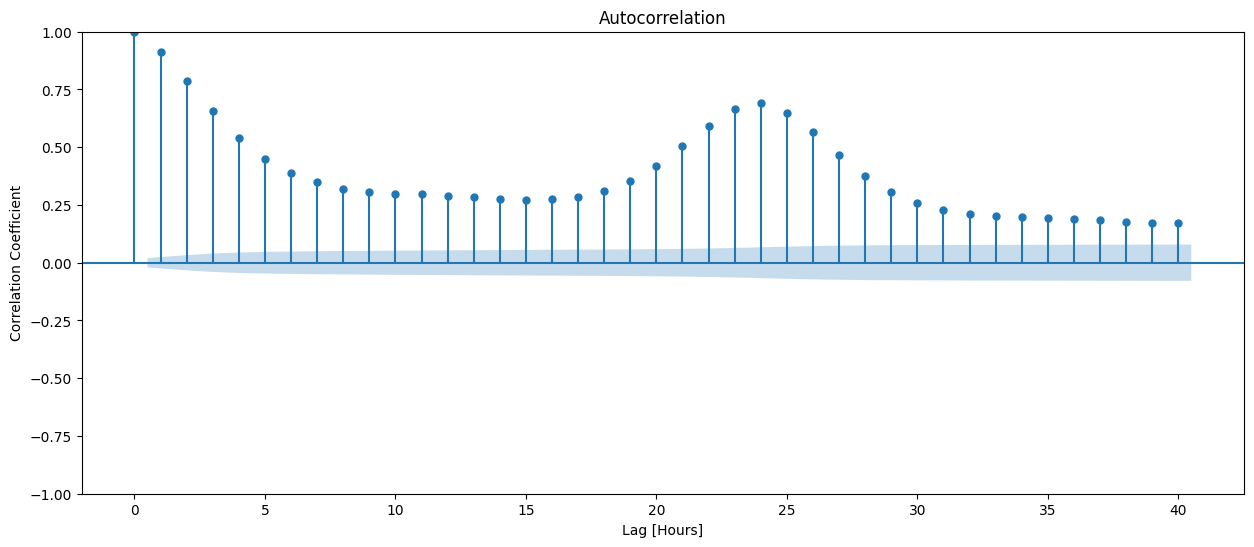

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient");

Autocorrelation(ACF) Plots visualizes how correlation changes over tiem giving us an insight of how many lags we would want to include in our model

### PACF PLOTS

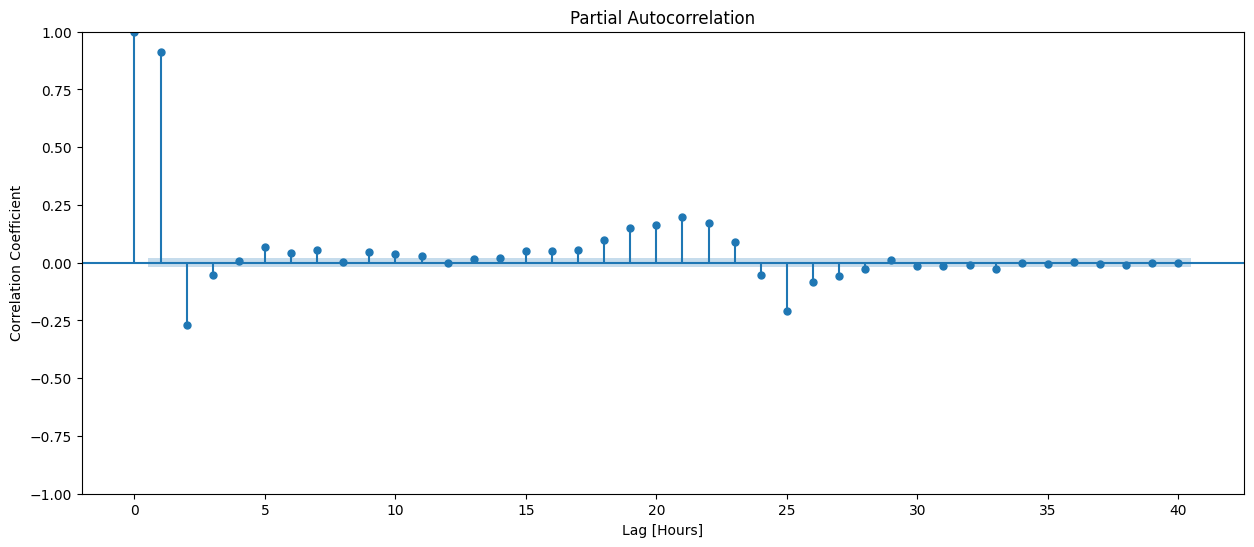

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient");

### **SPLIT**

Split data into training and test sets.

In [7]:
cut_off = int(len(y) * 0.95)
y_train = y.iloc[:cut_off]
y_test = y.iloc[cut_off:]

# Verify the lengths of the training and test sets
print("Length of training set:", len(y_train))
print("Length of test set:", len(y_test))

Length of training set: 8888
Length of test set: 468


## **BUILD MODEL**

### **BASELINE**

In [8]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean NO2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean NO2 Reading: 108.52
Baseline MAE: 37.19


### **ITERATE**

In [9]:
model = AutoReg(y_train, lags=25).fit()


**TRAINING PREDICTIONS**

In [10]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[25:], y_pred)
print("Training MAE:", round(training_mae, 2))

Training MAE: 11.7


**MODEL RESIDUALS**

In [11]:
# Calculate residuals
y_train_resid = model.resid
y_train_resid.head()

Timestamp
2004-03-11 19:00:00+01:00    26.172864
2004-03-11 20:00:00+01:00    -6.926051
2004-03-11 21:00:00+01:00   -20.669319
2004-03-11 22:00:00+01:00   -36.216312
2004-03-11 23:00:00+01:00   -17.329327
Freq: h, dtype: float64

**TIME SERIES: RESIDUALS**

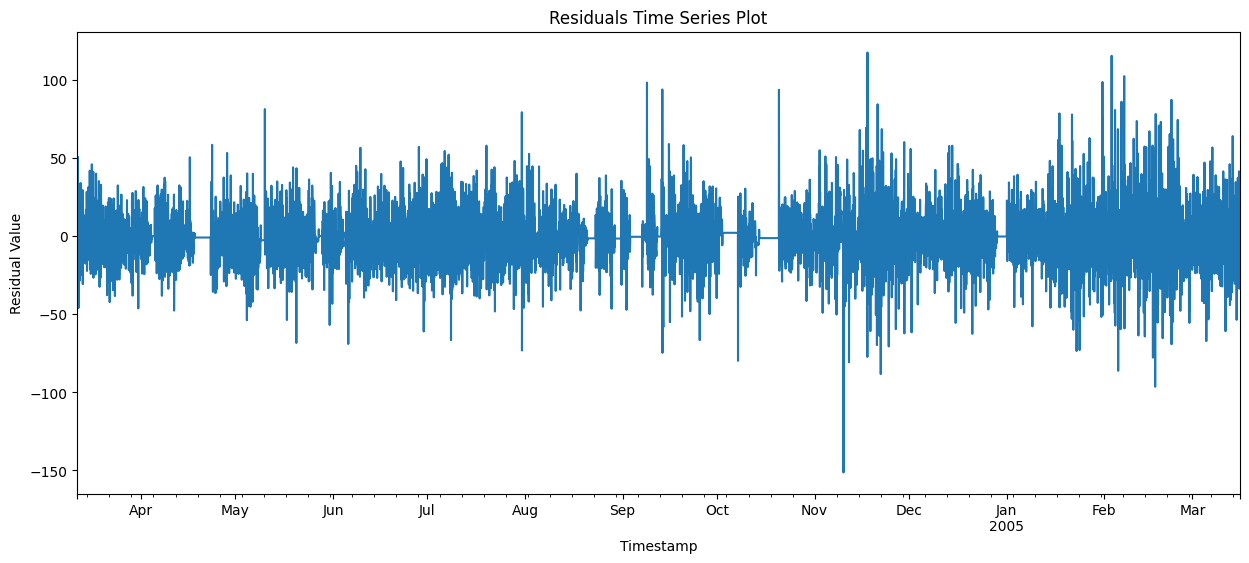

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax, ylabel="Residual Value", title="Residuals Time Series Plot");

**TIME SERIES: HISTOGRAM**

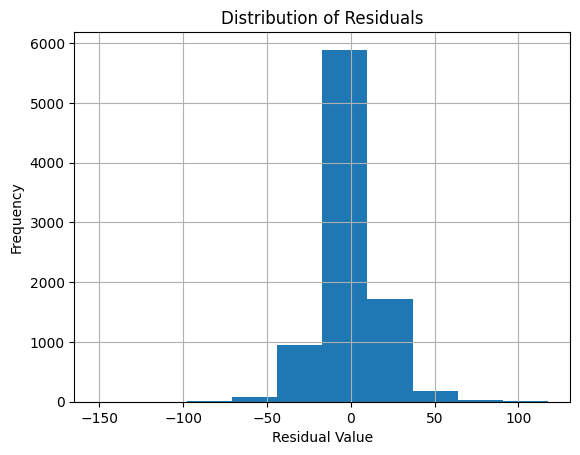

In [13]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals");


The histogram visualization enables us to verify that the residuals have a normal distribution.

**RESIDUALS: ACF PLOT**

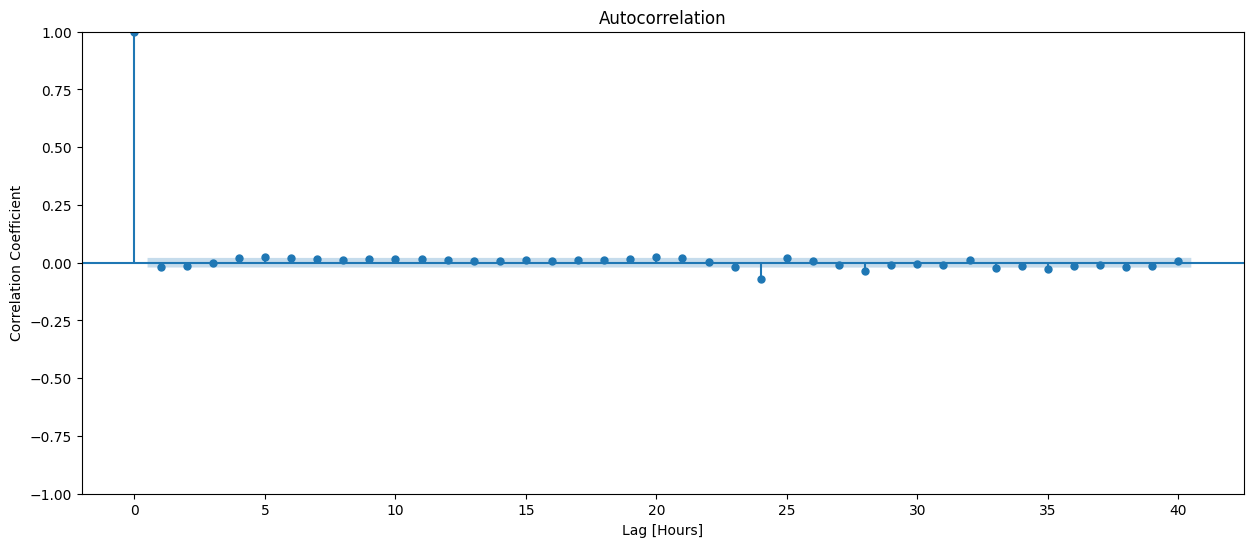

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient");

## **EVALUATE**

In [15]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", round(test_mae, 2))

Test MAE: 31.35


**PREDICTION DATAFRAME**

In [16]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test, "y_pred_test": y_pred_test,
    },
    index=y_test.index
)
df_pred_test.head()

,y_test,y_pred_test
Timestamp,,
2005-03-16 02:00:00+01:00,111.0,113.410017
2005-03-16 03:00:00+01:00,93.0,105.661507
2005-03-16 04:00:00+01:00,97.0,98.239409
2005-03-16 05:00:00+01:00,86.0,99.127774
2005-03-16 06:00:00+01:00,99.0,112.074720


**TEST PREDICITON PLOT**

In [17]:
fig = px.line(
    df_pred_test,
    labels={"value": "NO2"}
)
fig.show();

The predicition plot shows us that our model fails to generalize as it gets farther and farther away from the beigining. We can remedy this by using walk forward validation

**WALK FORWARD VALIDATION**

Our predictions lose power over time because the model gets farther and farther away from its beginning. But what if we could move that beginning forward with the model? That's what walk-forward validation is. In a walk-forward validation, we re-train the model at for each new observation in the dataset, dropping the data that's the farthest in the past.

In [21]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history ,lags=26).fit()
    next_pred=model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history=pd.concat([history, y_test[next_pred.index]])

In [22]:
len(y_pred_wfv)

468

**TEST EVALUATION**

In [19]:
# Add a placeholder prediction at the start (e.g., using the first prediction or mean value)
initial_prediction = [y_test.iloc[0]]  # or you can try [y_test.mean()]
y_pred_wfv = pd.Series(initial_prediction + predictions, index=y_test.index)

# Check the updated shape
print("Updated y_pred_wfv shape:", y_pred_wfv.shape)

# Now calculate MAE
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))


NameError: name 'predictions' is not defined

### **COMMUNICATE RESULTS**

**MODEL COEFFICIENTS**

In [23]:
print(model.params)

const          3.829237
NO2(GT).L1     0.990071
NO2(GT).L2    -0.120383
NO2(GT).L3    -0.014615
NO2(GT).L4    -0.053778
NO2(GT).L5     0.023818
NO2(GT).L6    -0.015055
NO2(GT).L7     0.057108
NO2(GT).L8    -0.041373
NO2(GT).L9     0.006101
NO2(GT).L10    0.001465
NO2(GT).L11    0.021813
NO2(GT).L12   -0.011266
NO2(GT).L13    0.007947
NO2(GT).L14   -0.019425
NO2(GT).L15    0.005471
NO2(GT).L16    0.012834
NO2(GT).L17   -0.011292
NO2(GT).L18   -0.009922
NO2(GT).L19    0.006993
NO2(GT).L20   -0.012650
NO2(GT).L21    0.018763
NO2(GT).L22    0.064596
NO2(GT).L23    0.109940
NO2(GT).L24    0.151260
NO2(GT).L25   -0.203551
dtype: float64


**PLOT WFV PREDICTIONS**

In [24]:
df_pred_test= pd.DataFrame(
    {"y_test":y_test ,"y_pred_wfv":y_pred_wfv}
    
)
fig = px.line(df_pred_test, labels={"value":"NO2"})
fig.show()